#经典的猫狗分类

##一、导入必要的库

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import cv2
from torchvision.models import resnet50
from torchvision.datasets import DatasetFolder
import matplotlib.pyplot as plt
import os
import random
import shutil
from shutil import copy2

##二、定义超参数

In [ ]:
train_file='train'
valid_file='valid'
test_file='test'
imagesize=32
batch_size=32
lr=1e-5
iters=10000

##三、数据集划分

将训练集划分为出验证集

In [4]:
def data_set_split(src_data_folder, target_data_folder, train_scale=0.8, val_scale=0.2):
    '''
    读取源数据文件夹，生成划分好的文件夹，分为trian、val、test三个文件夹进行
    :param src_data_folder: 源文件夹 
    :param target_data_folder: 目标文件夹 
    :param train_scale: 训练集比例
    :param val_scale: 验证集比例
    :param test_scale: 测试集比例
    :return:
    '''
    print("开始数据集划分")

    if not os.path.exists('/content/work'):
        os.mkdir('/content/work')
        
    class_names = os.listdir(src_data_folder)
    # 在目标目录下创建文件夹
    split_names = ['train', 'val']
    for split_name in split_names:
        split_path = os.path.join(target_data_folder, split_name)
        if os.path.isdir(split_path):
            pass
        else:
            os.mkdir(split_path)
        # 然后在split_path的目录下创建类别文件夹
        for class_name in class_names:
            class_split_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_split_path):
                pass
            else:
                os.mkdir(class_split_path)

    # 按照比例划分数据集，并进行数据图片的复制
    # 首先进行分类遍历
    for class_name in class_names:
        current_class_data_path = os.path.join(src_data_folder, class_name)
        current_all_data = os.listdir(current_class_data_path)
        current_data_length = len(current_all_data)
        current_data_index_list = list(range(current_data_length))
        random.shuffle(current_data_index_list)

        train_folder = os.path.join(os.path.join(target_data_folder, 'train'), class_name)
        val_folder = os.path.join(os.path.join(target_data_folder, 'val'), class_name)
        train_stop_flag = current_data_length * train_scale
        val_stop_flag = current_data_length * (train_scale + val_scale)
        current_idx = 0
        train_num = 0
        val_num = 0
        for i in current_data_index_list:
            src_img_path = os.path.join(current_class_data_path, current_all_data[i])
            if current_idx <= train_stop_flag:
                copy2(src_img_path, train_folder)
                # print("{}复制到了{}".format(src_img_path, train_folder))
                train_num = train_num + 1
            else:
                copy2(src_img_path, val_folder)
                # print("{}复制到了{}".format(src_img_path, val_folder))
                val_num = val_num + 1

            current_idx = current_idx + 1
            

        print("*********************************{}*************************************".format(class_name))
        print(
            "{}类按照{}：{}的比例划分完成，一共{}张图片".format(class_name, train_scale, val_scale, current_data_length))
        print("训练集{}：{}张".format(train_folder, train_num))
        print("验证集{}：{}张".format(val_folder, val_num))
        


if __name__ == '__main__':
    src_data_folder = "/content/drive/MyDrive/cat_dog/train"
    target_data_folder = "/content/work"
    data_set_split(src_data_folder, target_data_folder)

开始数据集划分
*********************************cats*************************************
cats类按照0.8：0.2的比例划分完成，一共279张图片
训练集/content/work/train/cats：224张
验证集/content/work/val/cats：55张
*********************************dogs*************************************
dogs类按照0.8：0.2的比例划分完成，一共278张图片
训练集/content/work/train/dogs：223张
验证集/content/work/val/dogs：55张


##四、数据预处理

In [5]:
# 定义数据预处理
class LoadImage(object):
    def __init__(self, imagesize):
        self.imagesize = imagesize
        
    def __call__(self, img_path):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.imagesize, self.imagesize))
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1))
        img = img / 255
        return img

# 构建Dataset
class FaceDataset(DatasetFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, loader=lambda x: x, extensions=('.jpg', '.jpeg', '.png'), transform=transform)

    def __getitem__(self, index):
        img_path, label = self.samples[index]
        label = np.array(label).astype(np.int64)
        label = np.expand_dims(label, axis=0)
        img = self.loader(img_path)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

train_file = "/content/work/train"
valid_file = "/content/work/val"

train_transforms = LoadImage(imagesize=224)
eval_transforms = LoadImage(imagesize=224)
train_dataset = FaceDataset(train_file, transform=train_transforms)
eval_dataset = FaceDataset(valid_file, transform=eval_transforms)

##五、图像查看

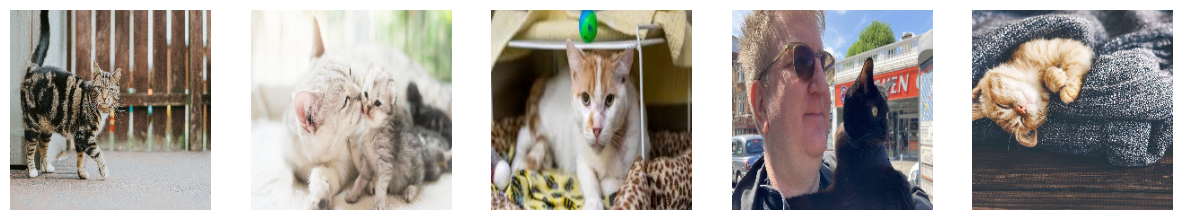

In [6]:
plt.figure(figsize=(15, 15))
for i in range(5):
    fundus_img, lab = train_dataset[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    plt.axis("off")

##六、模型组网

采用resnet50，之后又连接了两个全连接层

In [58]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.resnet.fc = nn.Identity() # 将最后一层全连接层替换为一个恒等映射，去掉预训练模型的分类层
        self.linear_1 = nn.Linear(2048, 512)
        self.linear_2 = nn.Linear(512, 256)
        self.linear_3 = nn.Linear(256, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, inputs):
        y = self.resnet(inputs)
        y = self.linear_1(y)
        y = self.linear_2(y)
        y = self.dropout(y)
        y = self.relu(y)
        y = self.linear_3(y)
        y = torch.sigmoid(y)
        y = F.softmax(y, dim=1)
        return y

In [59]:
model = Network()

##七、开始训练

In [60]:
def train(model, train_dataset, eval_dataset, batch_size=32, lr=1e-4, iters=100, save_every=10):
    # 定义优化器和损失函数
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # 定义 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

    # 将模型放入 GPU 上
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # 开始训练
    train_loss_list, eval_loss_list, eval_acc_list = [], [], []
    for i in range(iters):
        train_loss = 0.
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.shape[0]
        train_loss /= len(train_dataset)
        train_loss_list.append(train_loss)

        eval_loss, eval_acc = 0., 0.
        model.eval()
        with torch.no_grad():
            for x, y in eval_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = criterion(pred, y.squeeze())
                eval_loss += loss.item() * x.shape[0]
                eval_acc += (pred.argmax(dim=1) == y.squeeze()).sum().item()
        eval_loss /= len(eval_dataset)
        eval_acc /= len(eval_dataset)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)

        print(f'Iter {i+1}/{iters}, train_loss: {train_loss:.4f}, eval_loss: {eval_loss:.4f}, eval_acc: {eval_acc:.4f}')

        if (i+1) % save_every == 0:
            torch.save(model.state_dict(), f'model_{i+1}.pt')

    return train_loss_list, eval_loss_list, eval_acc_list


In [62]:
train(model, train_dataset, eval_dataset)

Iter 1/100, train_loss: 0.8713, eval_loss: 0.9019, eval_acc: 0.9091
Iter 2/100, train_loss: 0.8712, eval_loss: 0.8949, eval_acc: 0.9364
Iter 3/100, train_loss: 0.8713, eval_loss: 0.9008, eval_acc: 0.9182
Iter 4/100, train_loss: 0.8729, eval_loss: 0.8908, eval_acc: 0.9455
Iter 5/100, train_loss: 0.8712, eval_loss: 0.8948, eval_acc: 0.9455
Iter 6/100, train_loss: 0.8721, eval_loss: 0.8958, eval_acc: 0.9273
Iter 7/100, train_loss: 0.8720, eval_loss: 0.8970, eval_acc: 0.9273
Iter 8/100, train_loss: 0.8711, eval_loss: 0.8971, eval_acc: 0.9273
Iter 9/100, train_loss: 0.8711, eval_loss: 0.8969, eval_acc: 0.9273
Iter 10/100, train_loss: 0.8711, eval_loss: 0.9011, eval_acc: 0.9182
Iter 11/100, train_loss: 0.8711, eval_loss: 0.9001, eval_acc: 0.9182
Iter 12/100, train_loss: 0.8714, eval_loss: 0.8951, eval_acc: 0.9364
Iter 13/100, train_loss: 0.8711, eval_loss: 0.8985, eval_acc: 0.9182
Iter 14/100, train_loss: 0.8733, eval_loss: 0.9017, eval_acc: 0.9182
Iter 15/100, train_loss: 0.8751, eval_loss:

KeyboardInterrupt: ignored

##八、预测

In [63]:
def load_test(img_path):   
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    #resize
    img = cv2.resize(img,(imagesize,imagesize))
    img = np.array(img).astype('float32')
    # HWC to CHW 
    img = img.transpose((2,0,1))
    #Normalize
    img = img / 255         

    return img

test_dataset=[]
test_file = '/content/test'
for i in os.listdir(test_file):
    test_dataset.append(load_test(test_file+'//'+i))
    test_dataset.append(load_test(test_file+'//'+i))
test_dataset = np.array(test_dataset)

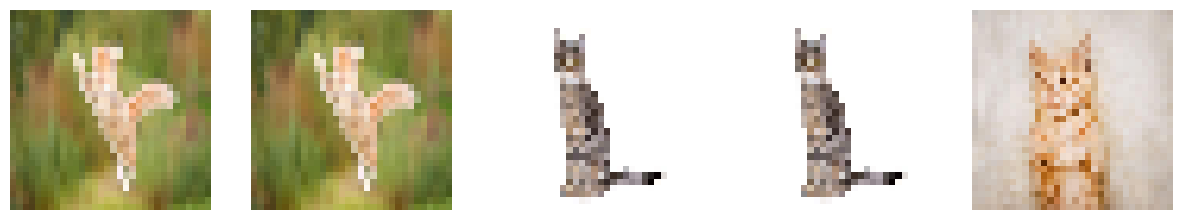

In [64]:
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_dataset[i].transpose(1, 2, 0))
    plt.axis("off")

In [65]:
# 加载模型并将其移动到指定设备上
best_model_path = "/content/model_10.pt"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

# 对测试集进行预测
result_list=[]
for test_data in test_dataset:
    test_data = torch.unsqueeze(torch.from_numpy(test_data), dim=0)
    test_data = test_data.to(device)
    result = model(test_data)
    result = result.detach().cpu().numpy()
    result_list.append(result)
result_list = np.array(result_list)

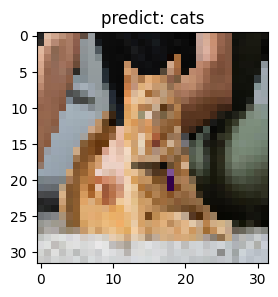

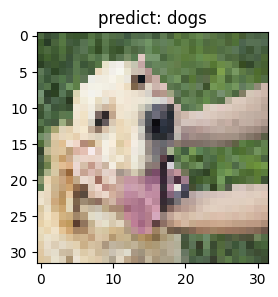

In [78]:
# 定义产出数字与分类的对应关系
face={1:'dogs',0:'cats'}

# 定义画图方法
def show_img(img, predict):
    plt.figure(figsize=(3, 3))
    plt.title('predict: {}'.format(face[predict]))
    plt.imshow(img.reshape([3, 32, 32]).transpose(1,2,0))
    plt.show()

# 抽样展示
indexs = [10, 119]

for idx in indexs:
    show_img(test_dataset[idx], np.argmax(result_list[idx]))